In [11]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
import glob
x_paths = glob.glob(r"D:\projects\brain tumor with vgg16 and random forest\yes\*.jpg")
y_paths = glob.glob(r"D:\projects\brain tumor with vgg16 and random forest\no\*.jpg")

In [13]:
print(len(x_paths))
print(len(y_paths))    

154
91


In [14]:
# combining the images
all_images = x_paths + y_paths

# creating the labels
all_labels = []

for _ in x_paths:
    all_labels.append(1)

for _ in y_paths:
    all_labels.append(0)

In [15]:
print(len(all_images))
print(len(all_labels))

245
245


In [17]:
# data augmentation

import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

# Set image size and how many augmented copies you want per image
IMG_SIZE = 224
AUG_PER_IMAGE = 3

# Create an image augmenter
augmentor = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Lists to store images and labels
X_data = []
y_data = []

# Loop through all images and labels
for img_path, label in zip(all_images, all_labels):
    # Load and resize the image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Preprocess and save the original image
    img_preprocessed = preprocess_input(img.astype(np.float32))
    X_data.append(img_preprocessed)
    y_data.append(label)

    # Expand dims for augmentation (add batch dimension)
    img_batch = np.expand_dims(img, axis=0)

    # Create augmented images
    for _ in range(AUG_PER_IMAGE):
        augmented = next(augmentor.flow(img_batch, batch_size=1))[0]
        augmented = preprocess_input(augmented.astype(np.float32))
        X_data.append(augmented)
        y_data.append(label)

# Convert to numpy arrays
X_final = np.array(X_data)
y_final = np.array(y_data)

# Final shapes
print("Total images after augmentation:", X_final.shape)
print("Total labels:", y_final.shape)


Total images after augmentation: (980, 224, 224, 3)
Total labels: (980,)


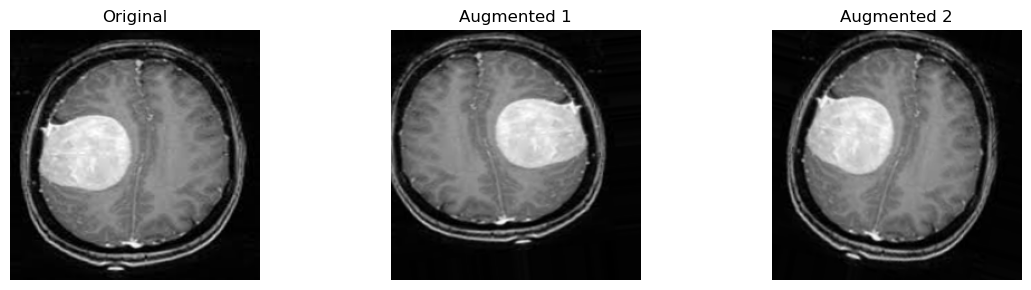

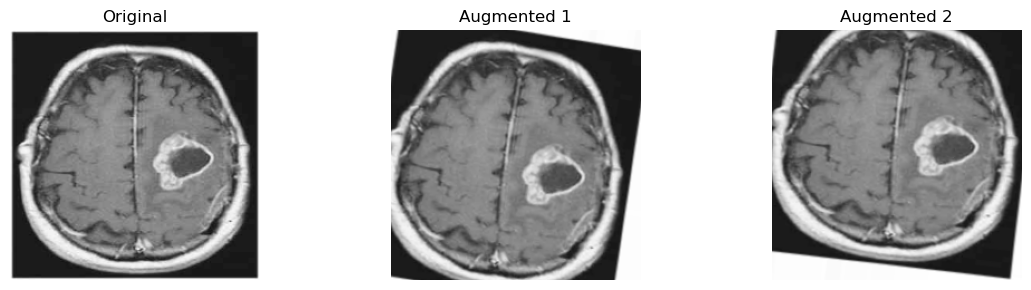

In [19]:
# Number of examples to show
num_examples = 2
augs_per_image = 2  # should match AUG_PER_IMAGE

# Go back to original image paths and read from disk again (if needed)
for idx in range(num_examples):
    # Load original image again
    img = cv2.imread(all_images[idx])
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Plot original image
    plt.figure(figsize=(12, 3))
    plt.subplot(1, augs_per_image + 1, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')

    # Generate and plot augmented images
    img_batch = np.expand_dims(img, axis=0)
    aug_iter = augmentor.flow(img_batch, batch_size=1)
    
    for i in range(augs_per_image):
        aug_img = next(aug_iter)[0].astype(np.uint8)  # Avoid over-preprocessing for display
        plt.subplot(1, augs_per_image + 1, i + 2)
        plt.imshow(aug_img)
        plt.title(f"Augmented {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [21]:
# load vgg16 model without top layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

# load vgg16
base_model = VGG16(weights='imagenet',include_top=False , input_shape=(IMG_SIZE,IMG_SIZE,3))
model = Model(inputs = base_model.input , outputs = base_model.output)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Extract features from X_final using VGG16
features = model.predict(X_final)

print("Feature shape from VGG16:", features.shape)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1818s 60s/step
Feature shape from VGG16: (980, 7, 7, 512)


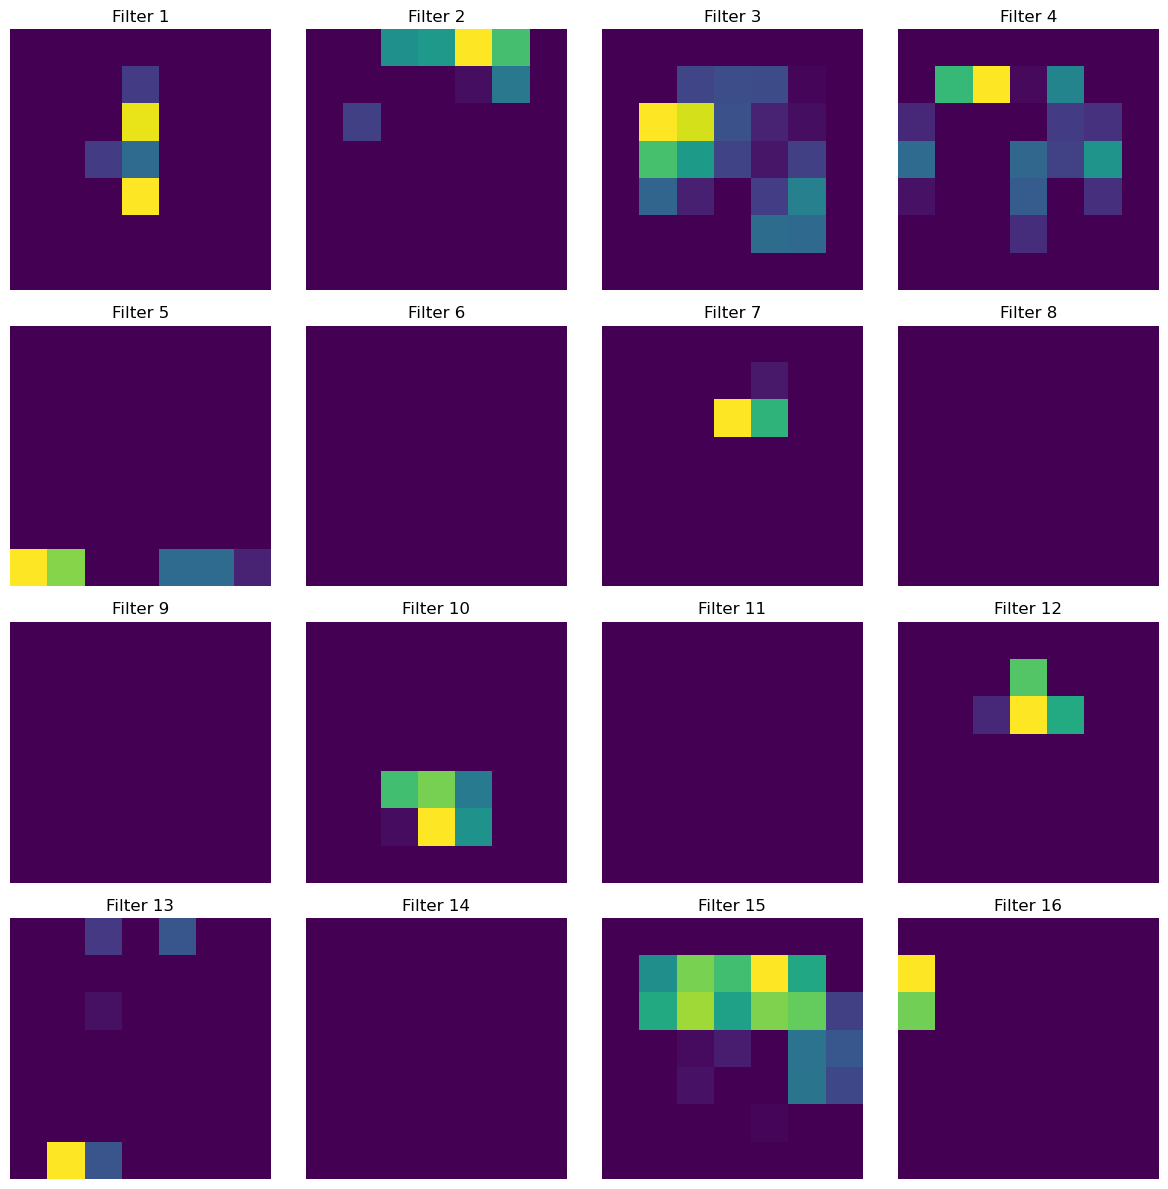

In [24]:
# visualizing the 16 feature extracted out of 512
feature_maps = features[0]

# Plot 16 out of 512 feature maps
plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(feature_maps[:, :, i], cmap='viridis')
    plt.axis('off')
    plt.title(f'Filter {i+1}')
plt.tight_layout()
plt.show()

In [26]:
# flatten the feature
X_features_flat = features.reshape(features.shape[0],-1)
print("Flattened features shape : ", X_features_flat.shape)

Flattened features shape :  (980, 25088)


In [27]:
# split the data 
from sklearn.model_selection import train_test_split
x_train , x_test ,y_train , y_test = train_test_split(X_features_flat , y_final , test_size=0.2 , random_state=42)

In [30]:
x_train.shape


(784, 25088)

In [31]:
x_test.shape

(196, 25088)

In [36]:
# using svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score , classification_report

# Train an SVM classifier
clf = SVC(kernel='linear', probability=True)
clf.fit(x_train, y_train)

# Predict
y_pred = clf.predict(x_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9795918367346939
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        69
           1       0.98      0.98      0.98       127

    accuracy                           0.98       196
   macro avg       0.98      0.98      0.98       196
weighted avg       0.98      0.98      0.98       196



In [38]:
# using random forest

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8928571428571429
              precision    recall  f1-score   support

           0       0.98      0.71      0.82        69
           1       0.86      0.99      0.92       127

    accuracy                           0.89       196
   macro avg       0.92      0.85      0.87       196
weighted avg       0.90      0.89      0.89       196



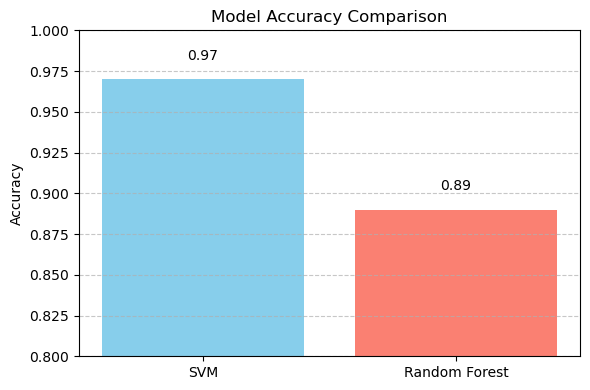

In [45]:
import matplotlib.pyplot as plt

# Accuracy values
models = ['SVM', 'Random Forest']
accuracy = [0.97, 0.89]

# Create bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(models, accuracy, color=['skyblue', 'salmon'])

# Add text labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01, f'{height:.2f}', ha='center', va='bottom')

# Labels and title
plt.ylim([0.80, 1.00])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
